In [280]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

## Encoder

In [281]:
class Encoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an LSTM. 
    Converts a sequence of token indices into a hidden representation 
    that will be used by the decoder for sequence generation.
    """
    def __init__(self, input_size, hidden_size):
        """
        Initializes the Encoder module.

        Args:
            input_size (int): The size of the input vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer converts token indices into dense vectors for better representation.
        # The embeddings refer to vector representations of words or tokens used as input to the model.
        # Instead of feeding raw word indices (which don’t capture meaning), feedingembeddings allows
        # the LSTM to learn meaningful semantic relationships between words.
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer processes embedded input sequences to generate hidden states
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input_seq):
        """
        Forward pass through the encoder.

        Args:
            input_seq (Tensor): Tensor containing token indices for a batch of input sentences.

        Returns:
            outputs (Tensor): Encoder outputs at each time step.
            hidden (Tensor): Final hidden state of the LSTM.
            cell (Tensor): Final cell state of the LSTM.
        """
        embedded = self.embedding(input_seq)            # Convert input tokens into embeddings 
        outputs, (hidden, cell) = self.lstm(embedded)   # Process embeddings through LSTM
        return outputs, (hidden, cell)

## Attention

In [282]:
class Attention(nn.Module):
    """ 
    Attention model for the sequence-to-sequence math problem assistant
    which implements a 'Bahdanau attention' mechanism. This allows the model
    to dynamically compute attention scores based on the decoder's hidden
    state and the encoder's outputs, allowing the model to focus on relevant
    parts of the input sequence at each decoding step.
    """
    def __init__(self, hidden_size):
        """
        Initializes the attention mechanism.

        Args:
            hidden_size (int): The size of the hidden state of the LSTM.
        """
        super(Attention, self).__init__()
        # Learnable linear transformation to compute alignment scores
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        # Learnable parameter to compute weighted attention scores
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        """
        Computes attention weights using Bahdanau's additive attention method.

        Args:
            hidden (Tensor): Decoder hidden state at the current time step.
            encoder_outputs (Tensor): Encoder outputs at all time steps.

        Returns:
            attention_weights (Tensor): Softmax-normalized attention scores.
        """
        seq_len = encoder_outputs.size(1)
        # Expand the hidden state across sequence length to match encoder outputs
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Compute energy scores (alignment) using a feed-forward layer
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # Transpose energy tensor for matrix multiplication with attention parameter
        energy = energy.permute(0, 2, 1)
        # Expand attention parameter across batch size
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        # Compute attention weights using learned vector `v`
        attention_weights = torch.bmm(v, energy).squeeze(1)
        # Apply softmax to normalize scores across sequence length
        return torch.softmax(attention_weights, dim=1)

## Decoder

In [283]:
class Decoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an
    LSTM with Bahdanau attention. The decoder generates output tokens one by one
    while dynamically focusing  on relevant parts of the encoder’s outputs using
    the attention mechanism.
    """
    def __init__(self, output_size, hidden_size):
        """
        Initializes the Decoder module.

        Args:
            output_size (int): The size of the output vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
        """
        super(Decoder, self).__init__()
        # Embedding layer converts token indices into dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)
        # LSTM layer processes embeddings and maintains hidden state across timesteps
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Linear layer maps concatenated attention context & LSTM output to vocab space
        self.fc = nn.Linear(hidden_size * 2, output_size)
        # Attention mechanism for dynamic focus on encoder outputs
        self.attention = Attention(hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        """
        Forward pass for the decoder.

        Args:
            input (Tensor): Current token input to the decoder.
            hidden (Tensor): Previous hidden state from the LSTM.
            cell (Tensor): Previous cell state from the LSTM.
            encoder_outputs (Tensor): Encoder outputs from all timesteps.

        Returns:
            output (Tensor): Predicted token probabilities.
            hidden (Tensor): Updated hidden state.
            cell (Tensor): Updated cell state.
            attention_weights (Tensor): Attention scores for each encoder timestep.
        """
        # Expand input dimensions to match expected input shape for embedding
        input = input.unsqueeze(1)  
        # Convert token indices into dense embeddings
        embedded = self.embedding(input)
        # Forward pass through LSTM to generate new hidden and cell states
        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # Compute attention weights using the current hidden state and encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)
        # Apply attention: generate weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # Flatten tensors for the fully connected layer
        lstm_output = lstm_output.squeeze(1)
        context = context.squeeze(1)
        # Generate token probabilities using concatenated LSTM output and attention context
        output = self.fc(torch.cat((lstm_output, context), dim=1))

        return output, hidden, cell, attention_weights

##  Basic Tokenization and Vocabulary Setup
First, create a vocabulary and tokenize the input sentence (e.g., "two plus four" etc). To keep things extremely simple we'll manually establish a 'word-to-index' vocabulary whihc offers a simple map from word to tokensized integer value.

In [284]:
# Tokenization and vocab setup
# Create a vocabulary mapping words to indices
word_to_index = {"<SOS>": 0, "<EOS>": 1, "<PAD>": 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Example input and target sequences
input_sentence = "two plus four"
target_sentence = "equals six"

# Test Tokenized input and targets
input_tokens = [word_to_index[word] for word in input_sentence.split()]
target_tokens = [word_to_index["<SOS>"]] + [word_to_index[word] for word in target_sentence.split()] + [word_to_index["<EOS>"]]

## Generate the math problem dataset from the tokenzied data

In [285]:
class BasicMathWordProblemDataset(Dataset):
    def __init__(self, input_sentences, target_sentences, word_to_index):
        self.input_data = [[word_to_index[word] for word in sentence.split()] for sentence in input_sentences]
        self.target_data = [[word_to_index["<SOS>"]] +
                            [word_to_index[word] for word in sentence.split()] +
                            [word_to_index["<EOS>"]] for sentence in target_sentences]

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return torch.tensor(self.input_data[idx], dtype=torch.long), torch.tensor(self.target_data[idx], dtype=torch.long)

# Example data
input_sentences = ["two plus four"]
target_sentences = ["equals six"]

# Create dataset and dataloader
dataset = BasicMathWordProblemDataset(input_sentences, target_sentences, word_to_index)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## Establish hyperparamters

In [286]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the encoder and decoder
input_size = len(word_to_index)  # Total vocabulary size
output_size = len(word_to_index)  # Vocabulary size
hidden_size = 128

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<PAD>"])  # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
attention_matrix = []  # Store attention weights for visualization

## Establish the training regime

In [287]:
def train(num_epochs, encoder_save_name, decoder_save_name):
    """
    Trains the sequence-to-sequence model using an encoder-decoder architecture.

    Args:
        num_epochs (int): Number of training epochs.
        encoder_save_name (str): File name for saving the trained encoder model.
        decoder_save_name (str): File name for saving the trained decoder model.
    """
    for epoch in range(num_epochs):
        for input_seq, target_seq in dataloader:
            # Move data to GPU if available, else keep on CPU
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)

            # Reset gradients before each batch
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # **ENCODER FORWARD PASS**
            # Processes the input sequence and generates context for the decoder
            encoder_outputs, (hidden, cell) = encoder(input_seq)

            # **DECODER INITIALIZATION**
            # The first input to the decoder is always the <SOS> token
            decoder_input = torch.tensor([word_to_index["<SOS>"]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell

            # Compute actual target sequence lengths (excluding padding)
            target_lengths = (target_seq != word_to_index["<PAD>"]).sum(dim=1)
            max_target_length = target_lengths.max().item()  # Maximum sequence length in batch

            loss = 0  # Track loss per batch
            
            # **ITERATE OVER TARGET SEQUENCE (Adaptive length)**
            for t in range(max_target_length):
                # Check if sequences are still active (haven't reached <EOS>)
                still_active = t < target_lengths
                if not still_active.any():  # If all sequences are finished, stop decoding
                    break

                # **DECODER FORWARD PASS**
                output, decoder_hidden, decoder_cell, attention_weights = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )

                # Compute masked loss (only valid tokens contribute to loss)
                loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()

                # Apply teacher forcing: Use actual target token as next input
                decoder_input = target_seq[:, t]  

            # **BACKPROPAGATION & OPTIMIZATION**
            loss.backward()  # Compute gradients
            encoder_optimizer.step()  # Update encoder weights
            decoder_optimizer.step()  # Update decoder weights

        # Print epoch loss for tracking progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
        attention_matrix.append(attention_weights.cpu().detach().numpy())  # Convert to NumPy for plotting
    
    # **SAVE TRAINED MODELS**
    torch.save(encoder.state_dict(), f"{encoder_save_name}.pth")
    torch.save(decoder.state_dict(), f"{decoder_save_name}.pth")

## Train the model

In [288]:
num_epochs = 100  # Define the number of epochs
train(num_epochs, "basic_math_problem_encoder", "basic_math_problem_decoder")

Epoch 1/100, Loss: 9.421306610107422
Epoch 2/100, Loss: 8.789353370666504
Epoch 3/100, Loss: 8.177886962890625
Epoch 4/100, Loss: 7.560642242431641
Epoch 5/100, Loss: 6.940435409545898
Epoch 6/100, Loss: 6.323278427124023
Epoch 7/100, Loss: 5.718662261962891
Epoch 8/100, Loss: 5.139210224151611
Epoch 9/100, Loss: 4.596834182739258
Epoch 10/100, Loss: 4.099666118621826
Epoch 11/100, Loss: 3.651379108428955
Epoch 12/100, Loss: 3.2523274421691895
Epoch 13/100, Loss: 2.900872230529785
Epoch 14/100, Loss: 2.593749523162842
Epoch 15/100, Loss: 2.3259994983673096
Epoch 16/100, Loss: 2.091553211212158
Epoch 17/100, Loss: 1.8844846487045288
Epoch 18/100, Loss: 1.7002047300338745
Epoch 19/100, Loss: 1.535854458808899
Epoch 20/100, Loss: 1.3896598815917969
Epoch 21/100, Loss: 1.2597596645355225
Epoch 22/100, Loss: 1.143677830696106
Epoch 23/100, Loss: 1.0390279293060303
Epoch 24/100, Loss: 0.9443627595901489
Epoch 25/100, Loss: 0.8590519428253174
Epoch 26/100, Loss: 0.7824059724807739
Epoch 27/10

## Generate heatmap

In [289]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(input_tokens, output_tokens, attention_matrix):
    """
    Plot the attention weights as a heatmap.

    Args:
        input_tokens (list of str): Tokens in the input sequence.
        output_tokens (list of str): Tokens in the output sequence.
        attention_matrix (np.array): Attention weights matrix (output_tokens x input_tokens).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis", interpolation="nearest")
    plt.xticks(ticks=np.arange(len(input_tokens)), labels=input_tokens, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(output_tokens)), labels=output_tokens)
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.show()

## Test setup

In [290]:
def test(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=100, with_attention_plot=False):
    # Set the models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through the encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize the decoder
    decoder_input = torch.tensor([word_to_index["<SOS>"]], dtype=torch.long)  # Start-of-Sequence token
    decoder_hidden = hidden
    decoder_cell = cell

    # Generate output sequence and collect attention weights
    output_sequence = []
    attention_matrices = []

    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, attention_weights = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get the token with the highest probability

        if predicted_token == word_to_index["<EOS>"]:  # Stop at End-of-Sequence token
            break

        output_sequence.append(predicted_token)
        attention_matrices.append(attention_weights.cpu().detach().numpy())  # Save attention weights

        decoder_input = torch.tensor([predicted_token], dtype=torch.long)  # Next decoder input

    # Convert input and output tokens to words
    input_sentence_tokens = [index_to_word[token] for token in input_tokens]
    output_sentence_tokens = [index_to_word[token] for token in output_sequence]

    # Stack attention matrices into a 2D array (output_tokens x input_tokens)
    attention_matrix = np.vstack(attention_matrices)

    # Print the input and output sentences
    print("Input Sentence:", input_sentence_tokens)
    print("Generated Sentence:", output_sentence_tokens)
    print("Attention Weights Shape:", attention_matrix)

    # Visualize attention
    if with_attention_plot:
        # Plot the attention weights
        plot_attention(input_sentence_tokens, output_sentence_tokens, attention_matrix)

## Test the trained model

In [291]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 128  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("basic_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("basic_math_problem_decoder.pth"))

input_sentence = "one plus two"

word_to_index = {"<SOS>": 0, "<EOS>": 1, "<PAD>": 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Test and visualize
test(encoder, decoder, input_sentence, word_to_index, index_to_word)

Input Sentence: ['one', 'plus', 'two']
Generated Sentence: ['<SOS>', 'equals', 'six']
Attention Weights Shape: [[0.16776235 0.6371486  0.19508912]
 [0.19927078 0.6194938  0.1812354 ]
 [0.15201887 0.6196428  0.22833826]]


# Establish a more complex dataset and train

## Establish a baseline vocabulary and tokenization capability

In [292]:
# Define special tokens
word_to_index = {"<SOS>": 0, "<EOS>": 1, "<PAD>": 2}  # establish only the baseline tokens this time
 
# Function to tokenize a sentence and update mapping dynamically
def tokenize(sentence, word_to_index):
    tokens = []
    for word in sentence.lower().split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)  # Assign index to new words
        tokens.append(word_to_index[word])
    return tokens

## Load CSV dataset from file

In [293]:
# Load dataset from CSV
def load_sequences_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df["Problem"].tolist(), df["Solution"].tolist()

csv_file = "simple_math_problems_addition_only.csv"
input_sentences, target_sentences = load_sequences_from_csv(csv_file)

## Tokenize input and target sentences and convert into tensors

In [294]:
# Tokenize input and target sentences
input_data = [tokenize(sentence, word_to_index) for sentence in input_sentences]
target_data = [[word_to_index["<SOS>"]] + tokenize(sentence, word_to_index) + [word_to_index["<EOS>"]]
               for sentence in target_sentences]

index_to_word = {v: k for k, v in word_to_index.items()}

# Convert tokenized sentences into tensors
input_tensors = [torch.tensor(seq) for seq in input_data]
target_tensors = [torch.tensor(seq) for seq in target_data]

## Generate the math problem dataset from the tokenzied data, including padding

In [295]:
# Apply dynamic padding
input_padded = pad_sequence(input_tensors, batch_first=True, padding_value=word_to_index["<PAD>"])
target_padded = pad_sequence(target_tensors, batch_first=True, padding_value=word_to_index["<PAD>"])

class DynamicMathWordProblemDataset(Dataset):
    def __init__(self, input_padded, target_padded):
        self.input_data = input_padded
        self.target_data = target_padded

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

dataset = DynamicMathWordProblemDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

## Establish hyperparamters

In [296]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(word_to_index)  # Vocabulary size
output_size = len(word_to_index)
hidden_size = 256

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<PAD>"])
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)#0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)#0.001)

num_epochs = 100  # Define the number of epochs
train(num_epochs, "addition_only_math_problem_encoder", "addition_only_math_problem_decoder")

Epoch 1/100, Loss: 6.253276348114014
Epoch 2/100, Loss: 4.660191059112549
Epoch 3/100, Loss: 4.057714462280273
Epoch 4/100, Loss: 3.254704475402832
Epoch 5/100, Loss: 2.457012176513672
Epoch 6/100, Loss: 1.8879307508468628
Epoch 7/100, Loss: 1.0339797735214233
Epoch 8/100, Loss: 0.4540209472179413
Epoch 9/100, Loss: 0.39220842719078064
Epoch 10/100, Loss: 0.18521679937839508
Epoch 11/100, Loss: 0.10625506192445755
Epoch 12/100, Loss: 0.17500664293766022
Epoch 13/100, Loss: 0.08446114510297775
Epoch 14/100, Loss: 0.04551088064908981
Epoch 15/100, Loss: 0.03134765848517418
Epoch 16/100, Loss: 0.026969825848937035
Epoch 17/100, Loss: 0.022070562466979027
Epoch 18/100, Loss: 0.018413597717881203
Epoch 19/100, Loss: 0.015657030045986176
Epoch 20/100, Loss: 0.013501527719199657
Epoch 21/100, Loss: 0.011711714789271355
Epoch 22/100, Loss: 0.010253261774778366
Epoch 23/100, Loss: 0.009016893804073334
Epoch 24/100, Loss: 0.007956234738230705
Epoch 25/100, Loss: 0.007043604273349047
Epoch 26/100

# Test the revised model

Input Sentence: ['thirty', 'eight', 'plus', 'twenty', 'six']
Generated Sentence: ['<SOS>', 'sixty', 'four']
Attention Weights Shape: [[6.0139322e-05 8.1848382e-05 1.6479433e-03 9.6513665e-01 3.3073444e-02]
 [4.7311822e-01 5.2379602e-01 3.6086902e-05 1.5776999e-04 2.8918239e-03]
 [6.1024840e-15 1.0028849e-12 1.8556992e-13 8.2386191e-07 9.9999917e-01]]


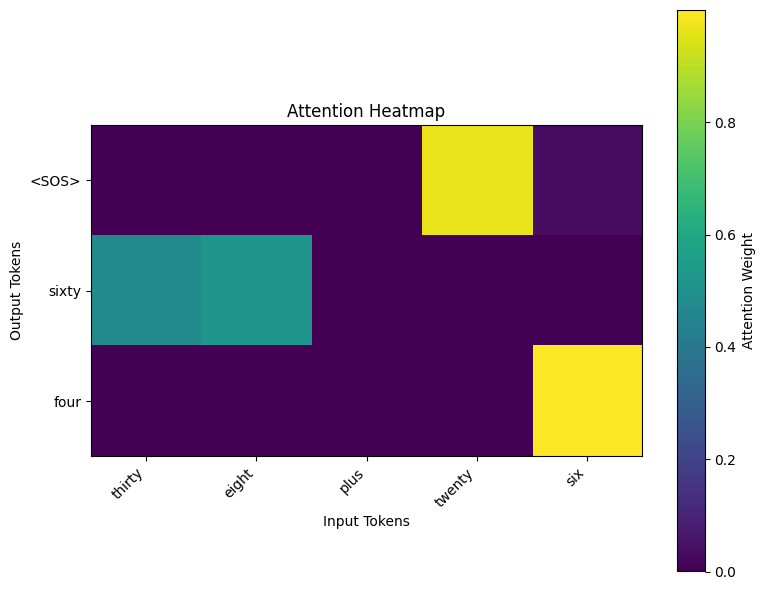

In [297]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 256  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("addition_only_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("addition_only_math_problem_decoder.pth"))

#thirty eight plus twenty seven,sixty five

input_sentence = "thirty eight plus twenty six" #sixty four

# Test and visualize
test(encoder, decoder, input_sentence, word_to_index, index_to_word, with_attention_plot=True)

## Evaluate with edit distance

In [ ]:
import edit_distance

def generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=10):
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize decoder with <SOS> token
    decoder_input = torch.tensor([word_to_index["<SOS>"]], dtype=torch.long)
    decoder_hidden, decoder_cell = hidden, cell

    # Generate output sequence
    output_sequence = []
    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, _ = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get token with highest probability
        if predicted_token == word_to_index["<EOS>"]:  # Stop at <EOS> token
            break
        output_sequence.append(predicted_token)
        decoder_input = torch.tensor([predicted_token], dtype=torch.long)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

def evaluate_with_edit_distance(test_data, encoder, decoder, word_to_index, index_to_word):
    """
    Evaluate the sequence-to-sequence model using edit distance.

    Args:
        test_data (list): List of (input_sentence, ground_truth_sentence) pairs.
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        word_to_index (dict): Word-to-index mapping.
        index_to_word (dict): Index-to-word mapping.

    Returns:
        float: Average edit distance across the test dataset.
    """
    total_distance = 0
    for input_sentence, ground_truth_sentence in test_data:
        # Generate predicted sequence
        predicted_sentence = generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word)

        # Compute edit distance
        distance = edit_distance.SequenceMatcher(a=ground_truth_sentence, b=predicted_sentence).distance()
        total_distance += distance

        # Debugging: Print example results
        print(f"Input: {input_sentence}")
        print(f"Ground Truth: {ground_truth_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"Edit Distance: {distance}\n")

    # Calculate average edit distance
    average_distance = total_distance / len(test_data)
    print(f"Average Edit Distance: {average_distance}")
    return average_distance


# Example dataset: [(input_sentence, ground_truth_sentence)]
test_data = [
    ("thirty eight plus twenty six", ["<SOS>", "sixty", "four"]),
]

# Assume you have trained encoder and decoder models
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

Input: thirty eight plus twenty six
Ground Truth: ['<SOS>', 'sixty', 'four']
Predicted: ['<SOS>', 'sixty', 'four']
Edit Distance: 0

Average Edit Distance: 0.0


## Tune hyperparameters

In [ ]:
# Objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters to be tuned
    hidden_size = trial.suggest_int("hidden_size", 128, 512)  # Hidden layer size
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # LR (log-scaled search)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    
    # Define encoder-decoder with suggested hyperparameters
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(output_size, hidden_size).to(device)

    # Apply dropout in LSTM layers
    encoder.lstm.dropout = dropout_rate
    decoder.lstm.dropout = dropout_rate

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<PAD>"])
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Run one epoch to evaluate hyperparameter performance
    total_loss = 0
    for input_seq, target_seq in dataloader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, (hidden, cell) = encoder(input_seq)
        decoder_input = torch.tensor([word_to_index["<SOS>"]] * input_seq.size(0), device=device)
        decoder_hidden, decoder_cell = hidden, cell

        loss = 0
        for t in range(target_seq.size(1)):
            output, decoder_hidden, decoder_cell, _ = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(output, target_seq[:, t])
            decoder_input = target_seq[:, t]  # Teacher forcing
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)  # Optuna minimizes this loss

## Perform optimum hyperparameter search


Best hyperparameters: {'hidden_size': 283, 'learning_rate': 0.004869044905756817, 'dropout_rate': 0.28901830138217327}

In [ ]:
import optuna

study = optuna.create_study(direction="minimize")  # Minimize loss
study.optimize(objective, n_trials=30)  # Run 30 optimization trials

# Print best hyperparameter combination
print("Best hyperparameters:", study.best_params)